In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leaf-disease-classification/Potato___healthy/7948ada9-eabc-4cb7-a579-b73e938eb716___RS_HL 4185.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966dc416f5___RS_HL 1840.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/5a3fc4bb-a78c-4276-8934-f0b037ffb860___RS_HL 5412.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/875d6ded-5f01-495c-a945-ad2e17f87f91___RS_HL 1848.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/4ae82355-6885-40e7-9807-dabe46ed3441___RS_HL 5410.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/f30983c0-6e20-43cc-8672-4622ca34c830___RS_HL 1949.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/5df30492-0b54-474d-8883-bba9474ca88f___RS_HL 1801.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/2e0b8b4b-e900-408b-b760-730690bbd382___RS_HL 1901.JPG
/kaggle/input/leaf-disease-classification/Potato___healthy/774875d3-438a-4305-afe2-7d59e2925dc4_

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from tensorflow.keras.layers import ( GlobalAveragePooling2D,Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,ReLU,RandomZoom)
from tensorflow.keras.regularizers  import L2, L1
from sklearn.metrics import confusion_matrix

2024-05-14 11:36:10.062182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 11:36:10.062323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 11:36:10.174152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
batch_size=32
im_size=256
channals=3

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/leaf-disease-classification',
    shuffle=True,
    batch_size=batch_size,
    image_size=(im_size,im_size)
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115., 104., 121.],
         [103.,  92., 109.],
         [100.,  89., 105.],
         ...,
         [102.,  91., 105.],
         [ 99.,  88., 102.],
         [ 96.,  85.,  99.]],

        [[122., 111., 128.],
         [126., 115., 132.],
         [129., 118., 134.],
         ...,
         [105.,  94., 108.],
         [103.,  92., 106.],
         [101.,  90., 104.]],

        [[110.,  99., 116.],
         [128., 117., 134.],
         [135., 124., 140.],
         ...,
         [108.,  97., 111.],
         [106.,  95., 109.],
         [106.,  95., 109.]],

        ...,

        [[149., 146., 157.],
         [153., 150., 161.],
         [159., 156., 167.],
         ...,
         [155., 151., 165.],
         [156., 152., 166.],
         [153., 149., 163.]],

        [[150., 147., 158.],
         [154., 151., 162.],
         [160., 157., 168.],
         ...,
         [158., 154., 168.],
         [157., 153., 167.],
       

In [8]:
plt.figure(figsize=(12,12))

for image,label in dataset.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i]/255)
        plt.title(class_names[label[i]])
        plt.axis("off")

In [9]:
len(dataset)*0.8

54.400000000000006

In [10]:
train_dataset=dataset.take(54)


In [11]:
test_dataset=dataset.skip(54)
len(test_dataset)

14

In [12]:
len(dataset)*0.1

6.800000000000001

In [13]:
val_dataset=test_dataset.take(6)
len(val_dataset)

6

In [14]:
test_dataset=test_dataset.skip(6)
len(test_dataset)

8

# data Preperation

In [15]:
train_dataset=(
    train_dataset
    .prefetch(tf.data.AUTOTUNE)   
    .shuffle(1000)
)

In [16]:
val_dataset=(
    val_dataset
    .prefetch(tf.data.AUTOTUNE)   
    .shuffle(1000)
)

In [17]:
resize_rescale=tf.keras.Sequential([
    Resizing(im_size,im_size),
    Rescaling(1./255)
    
])

In [18]:
augument=tf.keras.Sequential([
    #RandomContrast(factor=0.1),
    RandomFlip('horizontal_and_vertical'),
    RandomZoom(0.2)
])

def augument_layer(image,label):
    return augument(resize_rescale(image,training=True)),label

# Model Building

In [19]:
input_shape=(batch_size,im_size,im_size,channals)
model=tf.keras.Sequential([
    resize_rescale,
    augument,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax')

])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Transfer Learning

In [22]:
'''backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(im_size, im_size, 3),
    )'''

"backbone = tf.keras.applications.efficientnet.EfficientNetB4(\n    include_top = False,\n    weights='imagenet',\n    input_shape=(im_size, im_size, 3),\n    )"

In [23]:
#backbone.trainable=False

In [24]:
#from keras.models import Model

In [25]:
'''x=backbone.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024, activation = "relu")(x)
x=BatchNormalization()(x)
x=Dense(128, activation = "relu")(x)
prediction=Dense(3, activation = "softmax")(x)
pre_model=Model(inputs=backbone.input,outputs=prediction)'''

'x=backbone.output\nx=GlobalAveragePooling2D()(x)\nx=Dense(1024, activation = "relu")(x)\nx=BatchNormalization()(x)\nx=Dense(128, activation = "relu")(x)\nprediction=Dense(3, activation = "softmax")(x)\npre_model=Model(inputs=backbone.input,outputs=prediction)'

In [26]:
#pre_model.summary()

In [27]:
'''model=tf.keras.Sequential([
    Input(shape = (im_size, im_size,3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(1024, activation = "relu"),
    BatchNormalization(),
    Dense(128, activation = "relu"),
    Dense(3, activation = "softmax")
], name='my_efficientnet_model')

model.summary()'''

'model=tf.keras.Sequential([\n    Input(shape = (im_size, im_size,3)),\n    backbone,\n    GlobalAveragePooling2D(),\n    Dense(1024, activation = "relu"),\n    BatchNormalization(),\n    Dense(128, activation = "relu"),\n    Dense(3, activation = "softmax")\n], name=\'my_efficientnet_model\')\n\nmodel.summary()'

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history=model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.4539 - loss: 0.9227 - val_accuracy: 0.7292 - val_loss: 0.5845
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7149 - loss: 0.6285 - val_accuracy: 0.7344 - val_loss: 0.6447
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8036 - loss: 0.4389 - val_accuracy: 0.7969 - val_loss: 0.4977
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8326 - loss: 0.3914 - val_accuracy: 0.8542 - val_loss: 0.3760
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8691 - loss: 0.3351 - val_accuracy: 0.9010 - val_loss: 0.2103
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8864 - loss: 0.2892 - val_accuracy: 0.9323 - val_loss: 0.2138
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.8840 - loss: 0.2741 - val_accuracy: 0.9219 - val_loss: 0.2020
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9192 - loss: 0.1997 - val_accuracy: 0.8750 -

In [30]:
scores=model.evaluate(test_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9811 - loss: 0.0414


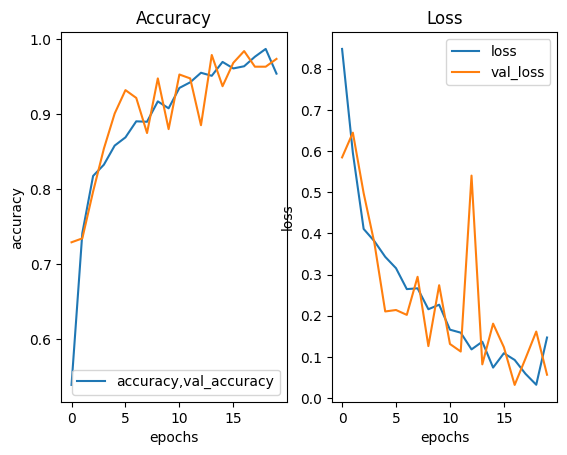

In [31]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy,val_accuracy'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

# Prediction

# Confusion Matrix

In [32]:
inp=[]
labels=[]
for x,y in test_dataset.take(1).as_numpy_iterator():
    inp.append(x)
    labels.append(y)

In [33]:
inp

[array([[[[161., 156., 162.],
          [165., 160., 166.],
          [164., 159., 165.],
          ...,
          [199., 205., 195.],
          [199., 207., 194.],
          [199., 207., 194.]],
 
         [[167., 162., 168.],
          [167., 162., 168.],
          [166., 161., 167.],
          ...,
          [208., 213., 207.],
          [212., 217., 210.],
          [212., 219., 211.]],
 
         [[166., 161., 167.],
          [162., 157., 163.],
          [163., 158., 164.],
          ...,
          [216., 217., 219.],
          [221., 225., 226.],
          [224., 228., 229.]],
 
         ...,
 
         [[142., 137., 144.],
          [138., 133., 140.],
          [137., 132., 139.],
          ...,
          [170., 167., 176.],
          [176., 173., 182.],
          [183., 180., 189.]],
 
         [[159., 154., 161.],
          [157., 152., 159.],
          [154., 149., 156.],
          ...,
          [172., 169., 178.],
          [177., 174., 183.],
          [183., 180., 189.

In [34]:
test_dataset

<_SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [35]:
val_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [36]:
predicted=model.predict(inp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [37]:
predicted_label=np.argmax(predicted,axis=1)

In [38]:
labels=np.array(labels)
labels=labels.flatten()

In [39]:
len(labels)


32

In [40]:
len(predicted_label)

32

In [41]:
labels

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int32)

In [42]:
predicted_label

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [43]:
import seaborn as sns

Text(45.722222222222214, 0.5, 'truth')

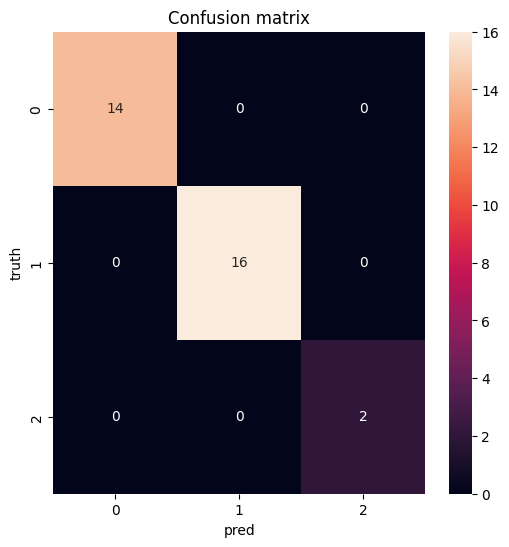

In [44]:
cm=confusion_matrix(labels,predicted_label)
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='d')
plt.title('Confusion matrix')
plt.xlabel('pred')
plt.ylabel('truth')

In [45]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) ## create batch
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


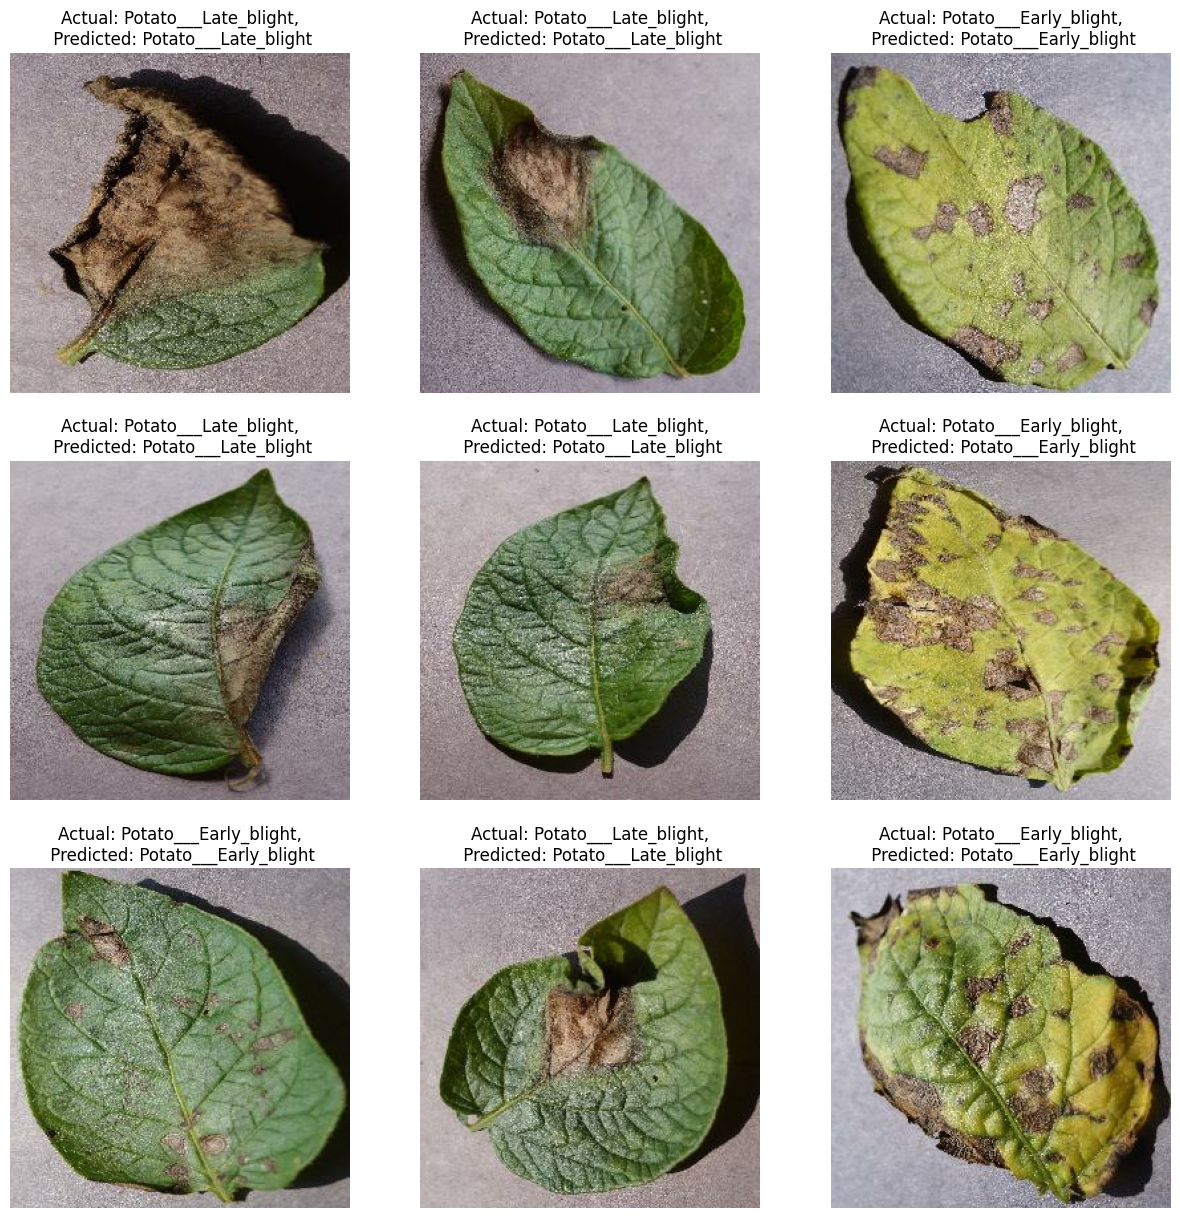

In [46]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        
        plt.axis("off")

# PREDICTION

In [47]:
from PIL import Image

In [48]:
CLASS_NAMES = ["Early Blight", "Late Blight", "Healthy"]
image_path='/kaggle/input/late-blight/potato.jpeg'
image = np.array(Image.open((image_path)))
img_batch = np.expand_dims(image, 0)
prediction=model.predict(img_batch)
predicted_class = CLASS_NAMES[np.argmax(prediction)]
confidence = np.max(prediction)
print(predicted_class)
confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Late Blight


0.99927694

In [49]:
model.save("/kaggle/working/model.h5")